In [1]:
# Dependencies
import re
import enchant
import wordninja
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.dataset.tweets import Tweets 

%matplotlib inline

years = [2018, 2019]
EN_DICT = enchant.Dict("en_US")

# Hashatag analysis

## Whole dataset

In [2]:
# Initialize Tweets object
tweets = { 2018 : Tweets(), 2019: Tweets() }

# Fill the datasets
tweets[2018].df = pd.read_json('./data/tweets_preGreta.json', dtype = { 'id': np.unicode_})
tweets[2019].df = pd.read_json('./data/tweets_postGreta.json', dtype = { 'id': np.unicode_})

# Uniform the column names to the class format
tweets[2018].df = tweets[2018].df.rename(columns = {'id': 'tweet_id','created_at': 'tweet_date','text': 'tweet_text'})
tweets[2019].df = tweets[2019].df.rename(columns = {'id': 'tweet_id','created_at': 'tweet_date','text': 'tweet_text'})

In [3]:
tweets[2018].df.head()

,tweet_date,tweet_id,tweet_text,hashtags,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2018-06-12 00:09:46+00:00,1006327664976617472,Our new paper in @NatureClimate shows that tem...,"[extremeweather, climatechange]",0,0,32.0,50.0
1,2018-06-12 00:09:40+00:00,1006327640226189318,“The transition to accessible and clean energy...,"[laudatosi, parisagreement]",0,0,128.0,174.0
2,2018-06-12 00:09:26+00:00,1006327582235688961,"The federal government won't lead on climate, ...","[wearestillin, parisagreement]",0,0,1349.0,2434.0
3,2018-06-12 00:09:26+00:00,1006327581556084736,Extreme Hurricane Rainfall Expected to Increas...,"[myccnotes, stayinformedcc, amoc, wutv, arctic...",1,0,NaN,NaN
4,2018-06-12 00:09:14+00:00,1006327528397697025,"""UN Women: Women To Be Heard When Tackling Cli...","[climatechange, climateaction, environment, en...",2,1,NaN,NaN


In [4]:
# Compute hashtags occurrences (dict {text : occurrences})
hash_counts = {}
for y in years: 
    hash_counts[y] = tweets[y].get_hashtag_counts()

In [5]:
# Plot function for hashtag occurrences
def plot_hashtags_occurrences(counts, year, n_hash_min = 0, n_hash_max = 20):
    # Convert the dictionary in a df, sort it by frequency
    hash_df = pd.DataFrame.from_dict(counts.items())
    hash_df.columns = ["hashtag", "occurrences"]
    hash_df.sort_values(by="occurrences", ascending=False, inplace=True)

    # Plot the barplot with the specified interval of the most frequent hashtags
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.set_title("Hashtag occurrences for {}'s tweets".format(year), fontsize=15)
    hash_df[n_hash_min : n_hash_max].plot(x="hashtag", y="occurrences", kind="bar", ax = ax)

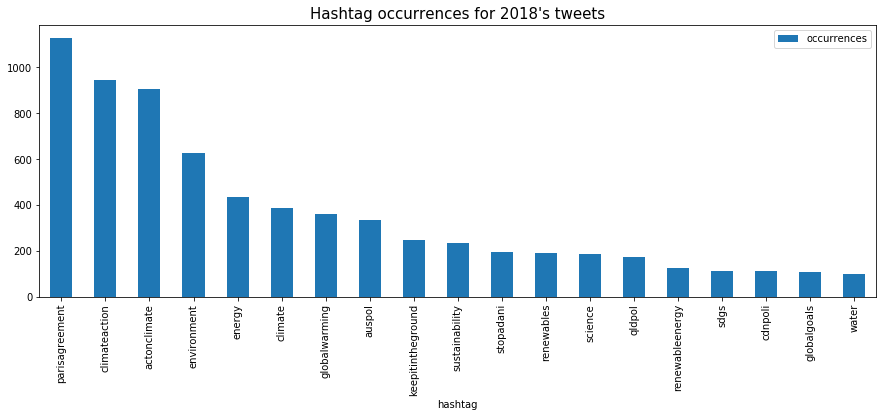

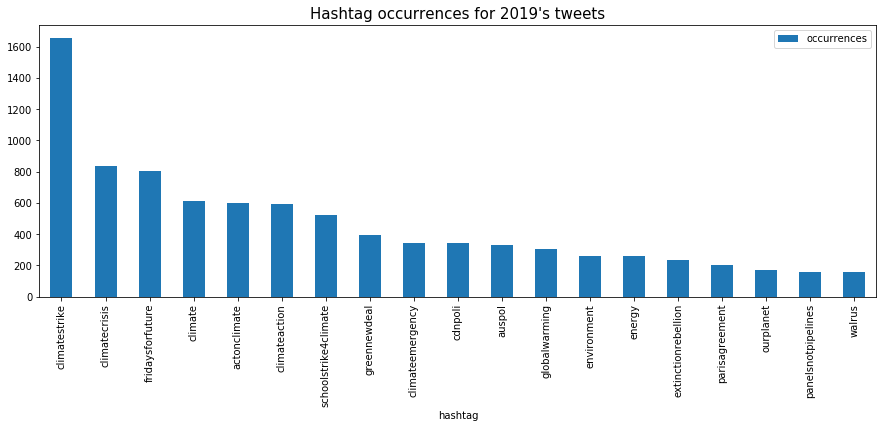

In [6]:
# Show hashtag occurences (without climatechange, too high)
for y in years:
    plot_hashtags_occurrences(hash_counts[y], y, n_hash_min = 1)

## ClimateChange dataset

### Sampling from tweets with #climatechange

In [7]:
# Define container for each year tweet
tweets_year = {2018: None, 2019: None}
# Define hashtags finder
find_hash = lambda x: bool(set(re.findall(r'#(\w+)', x.lower())) & set(['climatechange']))
# Make random sampling of tweets in either 2017 and 2018
for curr_year in tweets_year.keys():
    # Create a new empty tweets dataset
    curr_tweets = Tweets()
    # Subset current year tweets
    climate_mask = tweets[curr_year].df.tweet_text.apply(find_hash).values
    print('Shape tweets year', curr_year, ':', tweets[curr_year].df[climate_mask].shape)
    print()
    # Make samples on dataset indexes
    curr_tweets.df = tweets[curr_year].df[climate_mask].sample(
        n=5000,
        random_state=42,
        replace=False,
        axis=0
    )
    # Store sampled tweets
    tweets_year[curr_year] = curr_tweets

# Create a new sampled tweets dataset
tweets_sampled = Tweets()
tweets_sampled.df = pd.concat([tw.df for tw in tweets_year.values()], axis=0, ignore_index=True)
print('Shape sampled tweets:', tweets_sampled.df.shape)
tweets_sampled.df.head()

Shape tweets year 2018 : (8841, 8)

Shape tweets year 2019 : (6411, 8)

Shape sampled tweets: (10000, 8)


,tweet_date,tweet_id,tweet_text,hashtags,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2018-05-14 06:54:14+00:00,995920201844576256,"244,000 people have been displaced from their ...","[cholera, climatechange]",0,0,1.0,1.0
1,2018-06-24 05:10:01+00:00,1010751878379003906,"""Governments of richer countries that import p...","[actonclimate, climatechange]",0,0,165.0,178.0
2,2018-06-23 04:45:09+00:00,1010383231320018944,What makes you think that the environment can ...,"[climatechange, climateaction, environment, en...",0,0,NaN,NaN
3,2018-07-25 21:40:31+00:00,1022235170722611202,FACT: #animalagriculture is the single greates...,"[animalagriculture, climatechange, factoryfarm...",13,12,NaN,NaN
4,2018-05-21 10:15:02+00:00,998507450671169536,"Dr S. Achilleos presented the work ""Climate c...","[lifeprogramme, climatechange, climatechangecy...",0,0,2.0,10.0


In [8]:
# Compute hashtags occurrences (dict {text : occurrences})
sample_counts = {}
for y in years: 
    sample_counts[y] = tweets_year[y].get_hashtag_counts()

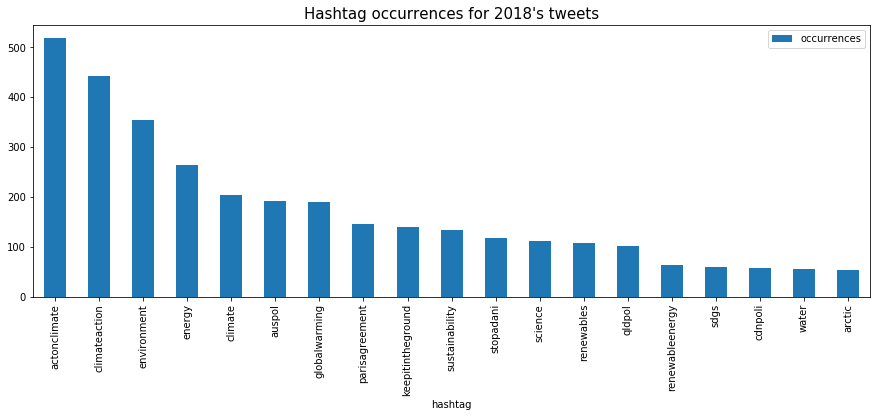

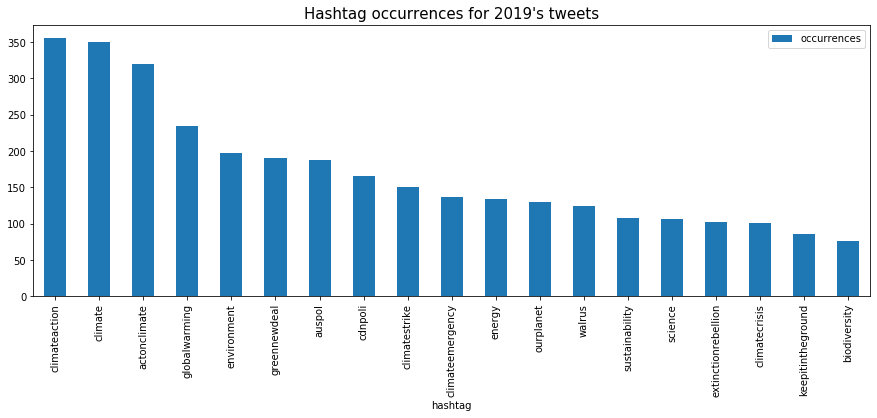

In [9]:
# Show hashtag occurences (without climatechange, it's in all tweets)
for y in years:
    plot_hashtags_occurrences(sample_counts[y], y, n_hash_min = 1)

### Split hashtags

In [10]:
hashtags = list(set(sample_counts[2018].keys()) | set(sample_counts[2019].keys()))
splittable_words = {}

for i, hashtag in enumerate(hashtags):
    # define the list of words obtained by splitting the hashtag
    hashtag_splitted = wordninja.split(hashtag)
    # check if the split consists in more than one word
    if (len(hashtag_splitted) > 1) and all([EN_DICT.check(word) for word in hashtag_splitted]):
        # save the word and the suggested splitting
        splittable_words[i] = [ hashtag,
                                str(hashtag_splitted),
                                sample_counts[2018].get(hashtag, 0),
                                sample_counts[2019].get(hashtag, 0)
                              ]
    else:
        # save the word with a None
        splittable_words[i] = [ hashtag,
                                pd.np.nan,
                                sample_counts[2018].get(hashtag, 0),
                                sample_counts[2019].get(hashtag, 0)
                              ]

splittable_words = pd.DataFrame.from_dict(splittable_words,
                        orient='index',
                        columns=["word", "proposed_splitting", "count_pre", "count_post"])

print(splittable_words.head())
# splittable_words.to_csv('./data/splittable_words.tsv',sep='\t')

               word        proposed_splitting  count_pre  count_post
0       aquaculture                       NaN          9           1
1  emergingdiseases  ['emerging', 'diseases']          0           1
2  ngorongorocrater                       NaN          0           1
3         resources                       NaN          1           0
4            sussex                       NaN          1           0


### Select most frequent hashtag to be splitted manually

In [11]:
# Join top_hash pre and post
top_hash = pd.DataFrame.from_dict(sample_counts[2018], orient='index', columns=['occurrences']).join(
           pd.DataFrame.from_dict(sample_counts[2019], orient='index', columns=['occurrences']), 
           how="outer", lsuffix="_pre", rsuffix="_post")

# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences_tot"] = top_hash.occurrences_pre + top_hash.occurrences_post

# Format (and save) the splitted dataset for the top hashtags
top_splitted = splittable_words.join(top_hash, on="word", how="right")

# Sort the hashtags according to frequency
top_splitted = top_splitted.sort_values(by="occurrences_tot", ascending=False)

# Remove useless columns
top_splitted = top_splitted[["word", "proposed_splitting"]]

# Select and save top 400 frequent values
bottom_splitted = top_splitted[400:]
top_splitted = top_splitted[:400]
# top_splitted.to_csv("data/top_400_hashtags_raw.tsv", sep='\t')

# Then the hashtags are manually curated and saved in data/hashtags_sub.json